In [1]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score ,roc_auc_score ,roc_curve, auc , precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_rows', 100)

# Random Forest

In [2]:
#reading the data
from scaled_data import *
df_X,df_y = clean_data()


In [ ]:
#https://www.featureranking.com/tutorials/machine-learning-tutorials/sk-part-2-feature-selection-and-ranking/

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from SpFtSel import SpFtSel
from sklearn.naive_bayes import BernoulliNB

X_SpF = df_X.copy()#.values

y_SpF = df_y#.values.ravel() # target


#Splitting data test&train 
X_train_SpF, X_test_SpF, y_train_SpF, y_test_SpF= train_test_split(X_SpF, y_SpF, test_size=0.25, random_state=123)


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
#sm =ADASYN(n_neighbors=20)
sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train_SpF,y_train_SpF)


X =  X_train_bal    #Feature Matrix
y = y_train_bal.values.ravel()         #Target Variable

# make sure the results are repeatable
np.random.seed(8)


x =X.values#.ravel()


# specify a wrapper to use
#wrapper =  LogisticRegression(solver = 'newton-cg',max_iter = 2000  ,class_weight={0:0.2,1:0.8},random_state=123 )
wrapper =  DecisionTreeClassifier(max_depth=3,random_state=123)
#wrapper = GradientBoostingClassifier(random_state=123,n_estimators=50,max_depth=5,min_samples_split=40)
#wrapper = BernoulliNB()
#wrapper = RandomForestClassifier()
#wrapper  =RandomForestClassifier(random_state=123,n_estimators=700,min_samples_split=60,class_weight={0:0.20,1:0.80})

# specify a metric to maximize
# (by default, sklearn metrics are defined as "higher is better")
# you need to make sure your scoring metric is consistent with your problem type,
# based on whether it is a binary or multi-class classification problem
# example: accuracy, f1, roc_auc, f1_weighted ,etc.
# more info on the scoring metrics can be found here:
# https://scikit-learn.org/stable/modules/model_evaluation.html
scoring = 'f1_weighted'

# set the engine parameters
sp_engine = SpFtSel(x, y, wrapper, scoring)

# run the engine
# available engine parameters:
# 1. num_features: how many features to select
#    (in addition to features to keep, if any)
#    default value is 0 and it results in automatic feature selection
# 2. run_mode: 'regular' (default) or 'extended'
# 3. stratified_cv: whether CV should be stratified or not (default is True)
#    stratified_cv must be set to False for regression problems
# 4. n_jobs: number of cores to be used in cross-validation (default is 1)
# 5. print_freq: print frequency for the output (default is 5)
# 6. features_to_keep_indices: indices of features to keep: default is None
sp_run = sp_engine.run(num_features=6 )#,stratified_cv = False)

# get the results of the run
sp_results = sp_run.results

# list of available keys in the engine output
print('Available keys:\n', sp_results.keys())

# performance value of the best feature set
print('Best value:', sp_results.get('best_value'))

# indices of selected features
print('Indices of selected features: ', sp_results.get('features'))

# importance of selected features
print('Importance of selected features: ', sp_results.get('importance').round(3))

# number of iterations for the optimal set
print('Total iterations for the optimal feature set:', sp_results.get('total_iter_for_opt'))
fs_indices_spsa = sp_results.get('features')

best_features_spsa = X.columns[fs_indices_spsa].values
best_features_spsa

In [4]:
# base model

rf_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)



from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=123)#,class_weight={0:0.20,1:0.80})

rf_model.fit(X_train,y_train)

rf_train_pred2= rf_model.predict(X_train)

rf_test_pred2 = rf_model.predict(X_test)


print("Training Metrics")
print("Accuracy:",accuracy_score(y_train,rf_train_pred2))
print("Precision:",precision_score(y_train,rf_train_pred2))
print("Recall:",recall_score(y_train,rf_train_pred2))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,rf_test_pred2))
print("Precision:",precision_score(y_test,rf_test_pred2))
print("Recall:",recall_score(y_test,rf_test_pred2))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,rf_test_pred2))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)



kf ='''rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(rf_model,X_train, y_train, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(rf_model,X_train, y_train, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())
'''


Training Metrics
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Test Metrics
Accuracy: 0.8864742134284788
Precision: 0.7043478260869566
Recall: 0.49490835030549896
Test Classification Report
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      2592
           1       0.70      0.49      0.58       491

    accuracy                           0.89      3083
   macro avg       0.81      0.73      0.76      3083
weighted avg       0.88      0.89      0.88      3083

Roc -Auc Curve 0.7277782492268235


Training Metrics
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Test Metrics
Accuracy: 0.8767434317223484
Precision: 0.6069364161849711
Recall: 0.6415478615071283
Test Classification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      2592
           1       0.61      0.64      0.62       491

    accuracy                           0.88      3083
   macro avg       0.77      0.78      0.78      3083
weighted avg       0.88      0.88      0.88      3083

Roc -Auc Curve 0.7814220789017123


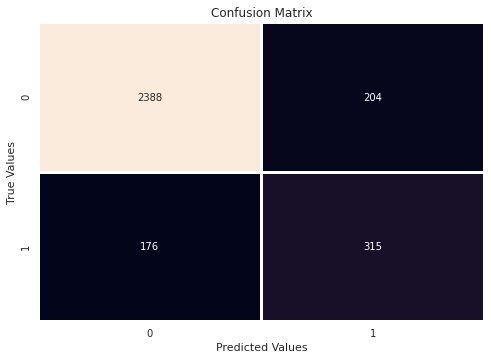

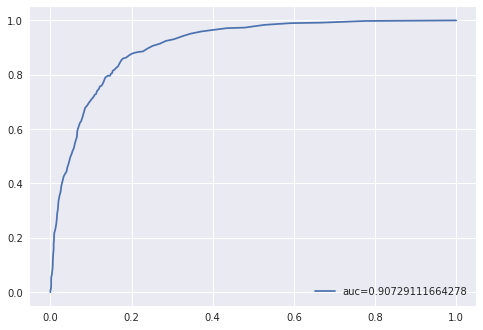

In [5]:
#with oversampling
#-------------------
rf_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=123)#,class_weight={0:0.20,1:0.80})

rf_model.fit(X_train_bal,y_train_bal)

rf_train_pred2= rf_model.predict(X_train_bal)

rf_test_pred2 = rf_model.predict(X_test)


print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,rf_train_pred2))
print("Precision:",precision_score(y_train_bal,rf_train_pred2))
print("Recall:",recall_score(y_train_bal,rf_train_pred2))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,rf_test_pred2))
print("Precision:",precision_score(y_test,rf_test_pred2))
print("Recall:",recall_score(y_test,rf_test_pred2))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,rf_test_pred2))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)


confusion_matrix = metrics.confusion_matrix(y_test, rf_test_pred2)

sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()



#####################


kf='''rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())'''



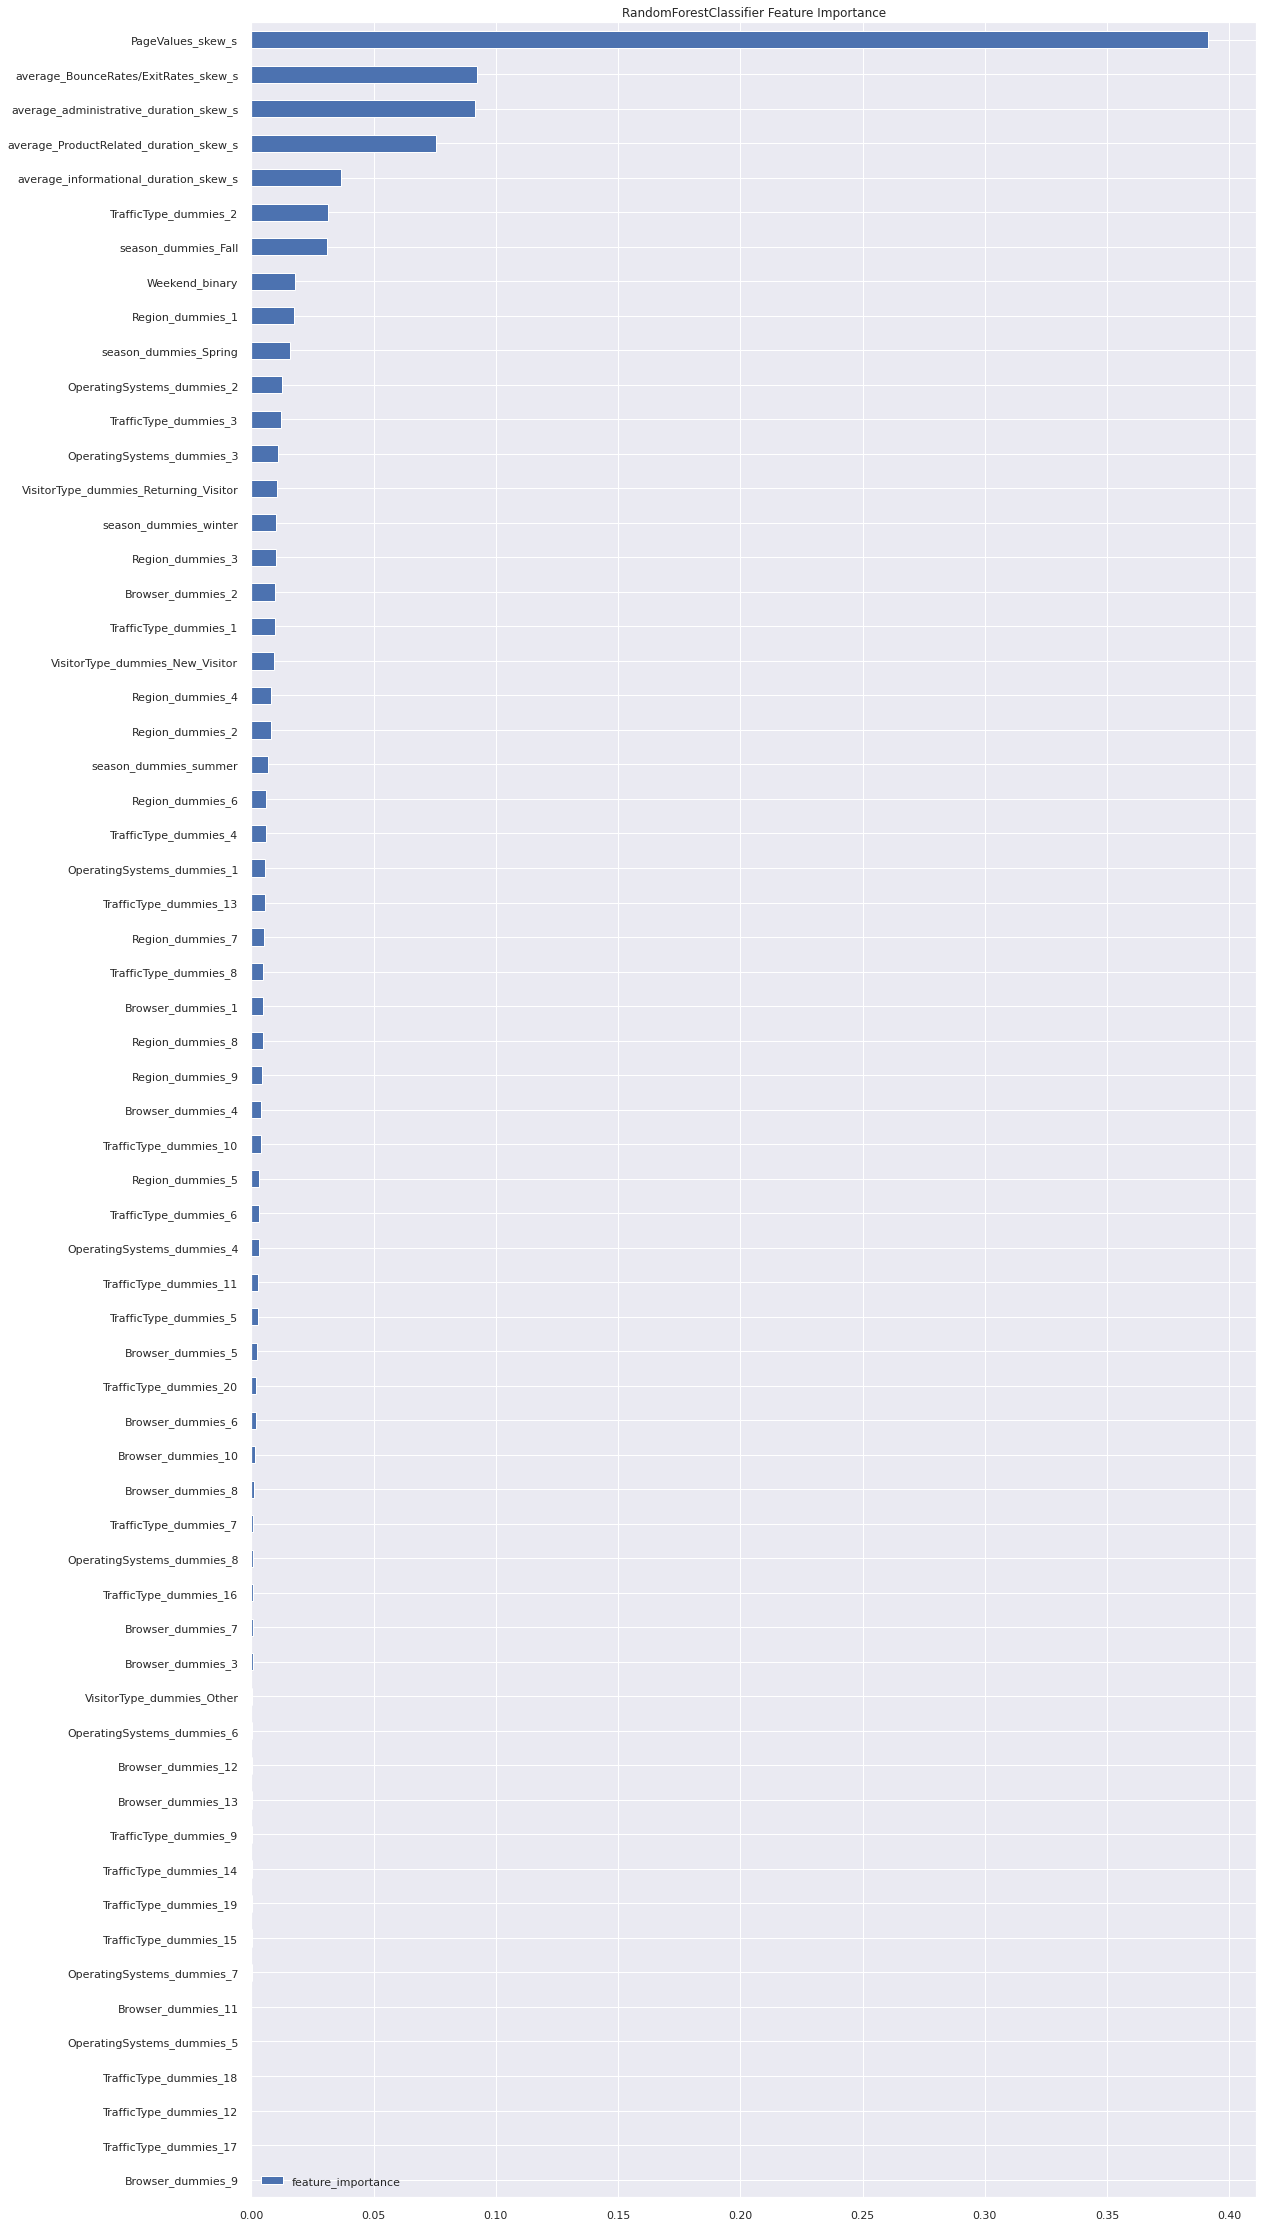

In [6]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(rf_model_Xdata.columns, rf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(18,40) ,title ='RandomForestClassifier Feature Importance')

In [8]:
importances.sort_values(by='feature_importance').tail(15).index

Index(['season_dummies_winter', 'VisitorType_dummies_Returning_Visitor', 'OperatingSystems_dummies_3', 'TrafficType_dummies_3', 'OperatingSystems_dummies_2', 'season_dummies_Spring',
       'Region_dummies_1', 'Weekend_binary', 'season_dummies_Fall', 'TrafficType_dummies_2', 'average_informational_duration_skew_s', 'average_ProductRelated_duration_skew_s',
       'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s'],
      dtype='object')

# Start GridSearchSV for tunning the


In [3]:

from scaled_data import *
df_X,df_y = clean_data()
rf_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)

---
# Tuning max_depth

In [9]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" :make_scorer(f1_score)}
scoring = {"f1" :make_scorer(f1_score)}
p_test1 = {'max_depth':[2,3,4,5,6,7] }


tuning = GridSearchCV(estimator =RandomForestClassifier( random_state=123), 
            param_grid = p_test1, scoring=scoring,n_jobs=4,iid=False, cv=5,refit='f1')

tuning.fit(X_train_bal,y_train_bal)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2262  330]
 [  98  393]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2592
           1       0.54      0.80      0.65       491

    accuracy                           0.86      3083
   macro avg       0.75      0.84      0.78      3083
weighted avg       0.89      0.86      0.87      3083

AUC 0.8365462585803726
f1 0.871187273023348


({'max_depth': 7}, 0.9046914343162801)

In [6]:
print("f1",f1_score(y_test,  y_pred))

f1 0.6474464579901152


---
# Tuning max_features

In [10]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : "f1_weighted"}
scoring = {"f1" :make_scorer(f1_score)}
p_test2 = {'max_features':[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}


tuning = GridSearchCV(estimator =RandomForestClassifier(max_depth =  7 ,random_state=123), 
            param_grid = p_test2, scoring=scoring,n_jobs=4,iid=False, cv=5,refit='f1')

tuning.fit(X_train_bal,y_train_bal)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)


print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2285  307]
 [ 107  384]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2592
           1       0.56      0.78      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.87      3083

AUC 0.8318180175253326
f1 0.8743817060172784


({'max_features': 15}, 0.907165340524546)

# Tuning min_samples_split & min_samples_leaf

In [11]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : "f1_weighted"}
scoring = {"f1" :make_scorer(f1_score)}
p_test3 = {'min_samples_split':[2,4,6,8,10,20,40,60,100],
           'min_samples_leaf':[1,3,5,7,9]}


tuning = GridSearchCV(estimator =RandomForestClassifier(max_depth =  7 ,max_features = 15 , random_state=123), 
            param_grid = p_test3, scoring=scoring,n_jobs=4,iid=False, cv=5,refit='f1')

tuning.fit(X_train_bal,y_train_bal)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2285  307]
 [ 107  384]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2592
           1       0.56      0.78      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.87      3083

AUC 0.8318180175253326
f1 0.8743817060172784


({'min_samples_leaf': 1, 'min_samples_split': 2}, 0.907165340524546)

# Tuning n_estimators

In [12]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RepeatedKFold
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score),"f1" : "f1_weighted"}
scoring = {"f1" :make_scorer(f1_score)}
p_test4 = {'n_estimators':[100,250,500,750,1000,1250,1500,1750]}


tuning = GridSearchCV(estimator =RandomForestClassifier(max_depth =  7 ,
                                                        max_features = 15 , 
                                                        min_samples_split = 2,
                                                        min_samples_leaf =1  ,
                                                        random_state=123), 
            param_grid = p_test4, scoring=scoring,n_jobs=-1,iid=False, cv=5,refit='f1')

tuning.fit(X_train_bal,y_train_bal)
y_pred = tuning.predict(X_test)

print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test,  y_pred)
print('AUC' ,roc_auc)

from sklearn.metrics import f1_score
print("f1",f1_score(y_test,  y_pred, average='weighted'))
tuning.best_params_, tuning.best_score_

/opt/tljh/user/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[[2285  307]
 [ 107  384]]
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2592
           1       0.56      0.78      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.87      3083

AUC 0.8318180175253326
f1 0.8743817060172784


({'n_estimators': 100}, 0.907165340524546)

# puting everthing togther after using GridSearchCV for tuning the hyperparameters

In [14]:

rf_model_Xdata = df_X.copy() #making our X columns


#getting the values of our x features:
#Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth =  7 ,
                                  max_features = 15 , 
                                  min_samples_split = 2,
                                  min_samples_leaf =1  , 
                                  n_estimators = 100 ,
                                  random_state=123)#,class_weight={0:0.20,1:0.80})

rf_model.fit(X_train_bal,y_train_bal)

rf_train_pred2= rf_model.predict(X_train_bal)

rf_test_pred2 = rf_model.predict(X_test)


print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,rf_train_pred2))
print("Precision:",precision_score(y_train_bal,rf_train_pred2))
print("Recall:",recall_score(y_train_bal,rf_train_pred2))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,rf_test_pred2))
print("Precision:",precision_score(y_test,rf_test_pred2))
print("Recall:",recall_score(y_test,rf_test_pred2))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,rf_test_pred2))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("f1",f1_score(y_test,   rf_test_pred2, average='weighted'))
print('Roc -Auc Curve',roc_auc)





##################

kf ='''rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())'''



Training Metrics
Accuracy: 0.9095785440613027
Precision: 0.900374531835206
Recall: 0.9210727969348659
Test Metrics
Accuracy: 0.8663639312358092
Precision: 0.556998556998557
Recall: 0.7861507128309573
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2592
           1       0.56      0.79      0.65       491

    accuracy                           0.87      3083
   macro avg       0.76      0.83      0.78      3083
weighted avg       0.89      0.87      0.88      3083

f1 0.8750544279540298
Roc -Auc Curve 0.8338546774031329


Roc -Auc Curve 0.8338546774031329


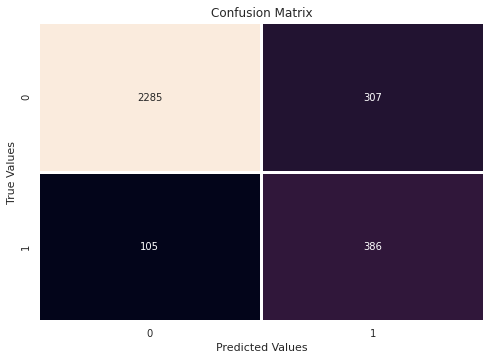

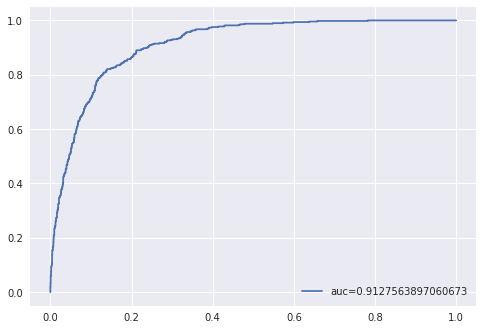

In [15]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)
confusion_matrix = metrics.confusion_matrix(y_test, rf_test_pred2)

sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()

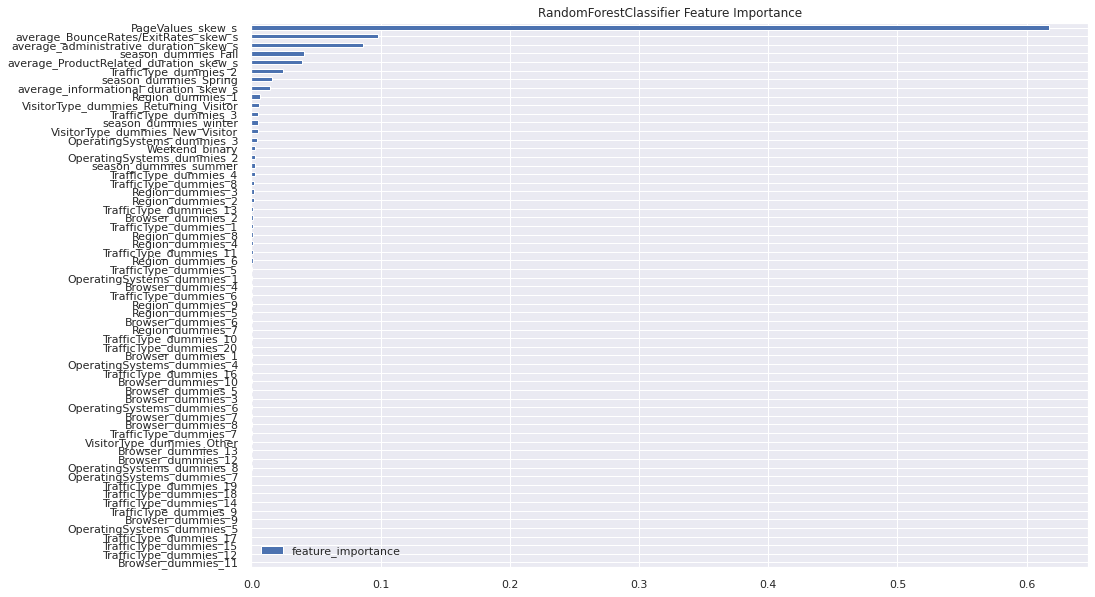

In [16]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(rf_model_Xdata.columns, rf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(15,10) ,title ='RandomForestClassifier Feature Importance')

In [18]:
importances.sort_values(by='feature_importance').tail(15).index

Index(['Weekend_binary', 'OperatingSystems_dummies_3', 'VisitorType_dummies_New_Visitor', 'season_dummies_winter', 'TrafficType_dummies_3', 'VisitorType_dummies_Returning_Visitor',
       'Region_dummies_1', 'average_informational_duration_skew_s', 'season_dummies_Spring', 'TrafficType_dummies_2', 'average_ProductRelated_duration_skew_s', 'season_dummies_Fall',
       'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s'],
      dtype='object')

## with Feature selection

Training Metrics
Accuracy: 0.9044061302681993
Precision: 0.8970532915360502
Recall: 0.9136653895274585
Test Metrics
Accuracy: 0.859552384041518
Precision: 0.5408450704225352
Recall: 0.7820773930753564
Test Classification Report
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      2592
           1       0.54      0.78      0.64       491

    accuracy                           0.86      3083
   macro avg       0.75      0.83      0.78      3083
weighted avg       0.89      0.86      0.87      3083

f1 0.8692600728336234
Roc -Auc Curve 0.8281528940685424


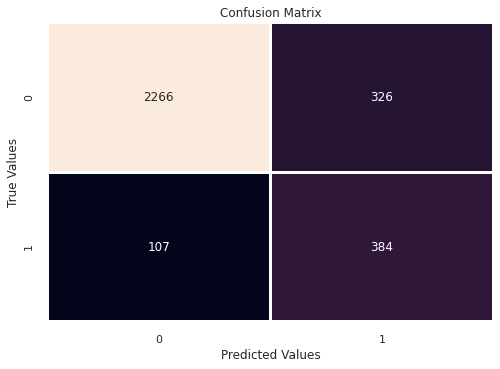

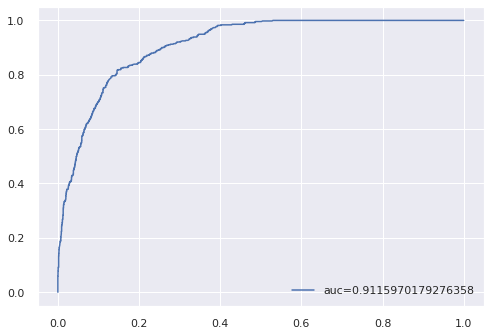

model bias (f1-score): 0.8963194624736254
model variance (f1-score): 0.005725387625666111
model bias (ROC/AUC): 0.9577806047192691
model variance (ROC/AUC): 0.0030066534748572097


In [23]:
rf_model_Xdata = df_X.copy() #making our X columns

best_features_spsa =['Weekend_binary', 'OperatingSystems_dummies_3', 'VisitorType_dummies_New_Visitor', 'season_dummies_winter', 'TrafficType_dummies_3', 'VisitorType_dummies_Returning_Visitor',
       'Region_dummies_1', 'average_informational_duration_skew_s', 'season_dummies_Spring', 'TrafficType_dummies_2', 'average_ProductRelated_duration_skew_s', 'season_dummies_Fall',
       'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s']
#getting the values of our x features:
Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
#Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth =  7 ,
                                  max_features = 15 , 
                                  min_samples_split = 2,
                                  min_samples_leaf =1  , 
                                  n_estimators = 100 ,
                                  random_state=123)#,class_weight={0:0.20,1:0.80})

rf_model.fit(X_train_bal,y_train_bal)

rf_train_pred2= rf_model.predict(X_train_bal)

rf_test_pred2 = rf_model.predict(X_test)


print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,rf_train_pred2))
print("Precision:",precision_score(y_train_bal,rf_train_pred2))
print("Recall:",recall_score(y_train_bal,rf_train_pred2))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,rf_test_pred2))
print("Precision:",precision_score(y_test,rf_test_pred2))
print("Recall:",recall_score(y_test,rf_test_pred2))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,rf_test_pred2))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("f1",f1_score(y_test,   rf_test_pred2, average='weighted'))
print('Roc -Auc Curve',roc_auc)

confusion_matrix = metrics.confusion_matrix(y_test, rf_test_pred2)

sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()



##################



rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=1750,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

Index(['Region_dummies_1', 'Weekend_binary', 'season_dummies_winter', 'VisitorType_dummies_New_Visitor', 'average_informational_duration_skew_s', 'VisitorType_dummies_Returning_Visitor',
       'TrafficType_dummies_3', 'season_dummies_Spring', 'TrafficType_dummies_2', 'OperatingSystems_dummies_3', 'season_dummies_Fall', 'average_ProductRelated_duration_skew_s',
       'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s'],
      dtype='object')

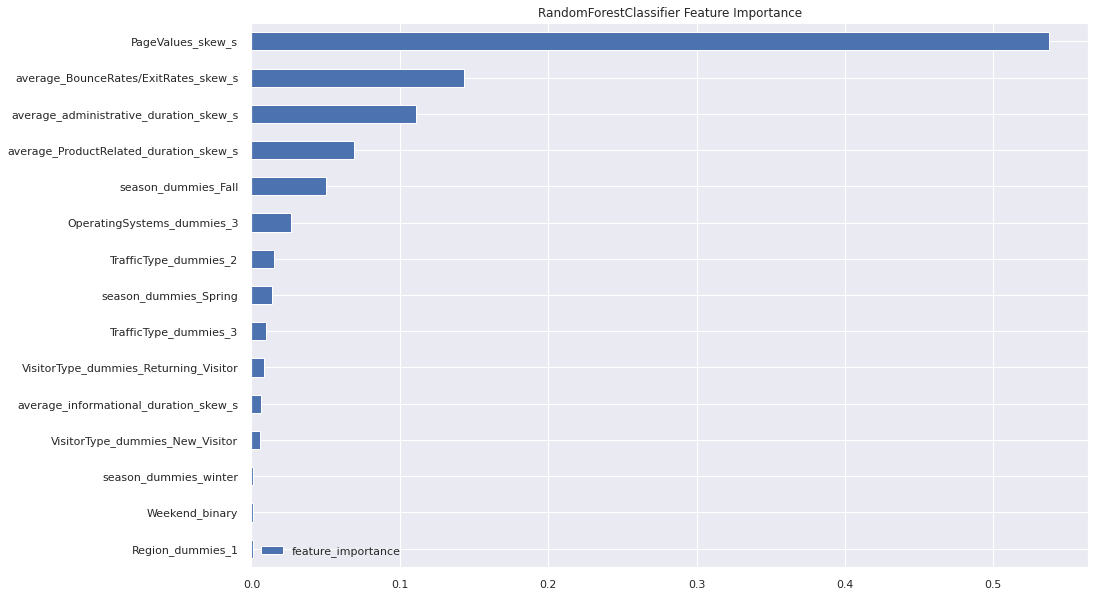

In [20]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(best_features_spsa, rf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(15,10) ,title ='RandomForestClassifier Feature Importance')
importances.sort_values(by='feature_importance').index

Training Metrics
Accuracy: 0.903448275862069
Precision: 0.8930082109977606
Recall: 0.9167305236270753
Test Metrics
Accuracy: 0.8533895556276354
Precision: 0.5264586160108549
Recall: 0.790224032586558
Test Classification Report
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      2592
           1       0.53      0.79      0.63       491

    accuracy                           0.85      3083
   macro avg       0.74      0.83      0.77      3083
weighted avg       0.89      0.85      0.86      3083

Roc -Auc Curve 0.8277894854290815


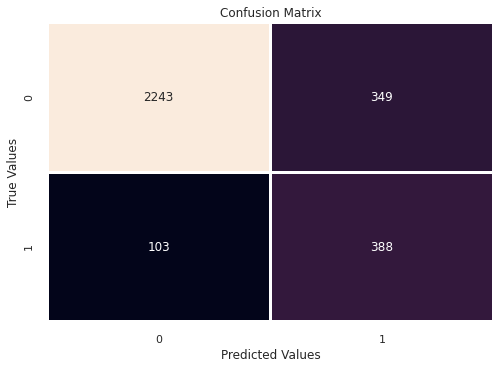

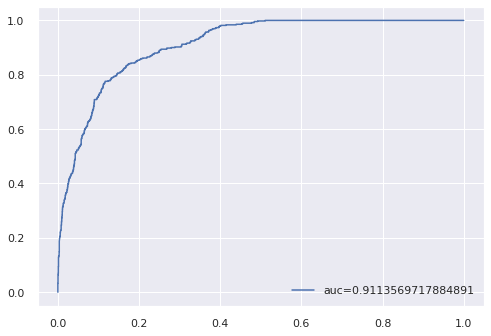

model bias (f1-score): 0.8972891304926534
model variance (f1-score): 0.005816953285542702
model bias (ROC/AUC): 0.9599354283948677
model variance (ROC/AUC): 0.0032279891902858293


In [24]:
rf_model_Xdata = df_X.copy() #making our X columns

best_features_spsa = ['Region_dummies_1', 'TrafficType_dummies_11', 'season_dummies_winter', 'Weekend_binary',
       'VisitorType_dummies_New_Visitor', 'VisitorType_dummies_Returning_Visitor', 'OperatingSystems_dummies_2', 'TrafficType_dummies_3', 'average_informational_duration_skew_s',
       'OperatingSystems_dummies_3', 'season_dummies_Spring', 'TrafficType_dummies_2', 'season_dummies_Fall', 'average_ProductRelated_duration_skew_s', 'average_administrative_duration_skew_s',
       'average_BounceRates/ExitRates_skew_s', 'PageValues_skew_s']
#getting the values of our x features:
Xrf_model = rf_model_Xdata[best_features_spsa].values
#Xrf_model= rf_model_Xdata[cols_2].values
#Xrf_model = rf_model_Xdata.values

#getting the values of our y:
y_rf_model = df_y.values.ravel() # target



#Splitting data test&train 
X_train, X_test, y_train, y_test= train_test_split(Xrf_model, y_rf_model , test_size=0.25, random_state=123)

from imblearn.over_sampling import SMOTE

sm =SMOTE(k_neighbors=20)
X_train_bal, y_train_bal = sm.fit_sample(X_train, y_train)


from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth =  7 ,
                                  max_features = 15 , 
                                  min_samples_split = 2,
                                  min_samples_leaf =1  , 
                                  n_estimators = 100 ,
                                  random_state=123)

rf_model.fit(X_train_bal,y_train_bal)

rf_train_pred2= rf_model.predict(X_train_bal)

rf_test_pred2 = rf_model.predict(X_test)


print("Training Metrics")
print("Accuracy:",accuracy_score(y_train_bal,rf_train_pred2))
print("Precision:",precision_score(y_train_bal,rf_train_pred2))
print("Recall:",recall_score(y_train_bal,rf_train_pred2))


print("Test Metrics")
print("Accuracy:",accuracy_score(y_test,rf_test_pred2))
print("Precision:",precision_score(y_test,rf_test_pred2))
print("Recall:",recall_score(y_test,rf_test_pred2))


from sklearn.metrics import classification_report
print('Test Classification Report')
print(classification_report(y_test,rf_test_pred2))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, rf_test_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)

print('Roc -Auc Curve',roc_auc)

confusion_matrix = metrics.confusion_matrix(y_test, rf_test_pred2)

sns.heatmap(confusion_matrix,annot=True,
            lw =2,
            cbar=False,
            fmt="d"
           )
plt.ylabel("True Values")
plt.xlabel("Predicted Values")
plt.title("Confusion Matrix")
plt.show()

y_pred_proba = rf_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="auc="+str(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.legend(loc="best")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.show()





##################


rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=123)
f1_scores_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='f1', cv=rkf)
roc_auc_cv = cross_val_score(rf_model,X_train_bal, y_train_bal, scoring='roc_auc', cv=rkf)

print("model bias (f1-score):", f1_scores_cv.mean())
print("model variance (f1-score):", f1_scores_cv.std())
print("model bias (ROC/AUC):", roc_auc_cv.mean())
print("model variance (ROC/AUC):", roc_auc_cv.std())


Index(['TrafficType_dummies_11', 'OperatingSystems_dummies_3', 'average_ProductRelated_duration_skew_s', 'season_dummies_Spring', 'average_informational_duration_skew_s', 'TrafficType_dummies_2',
       'average_administrative_duration_skew_s', 'average_BounceRates/ExitRates_skew_s', 'season_dummies_Fall', 'PageValues_skew_s'],
      dtype='object')

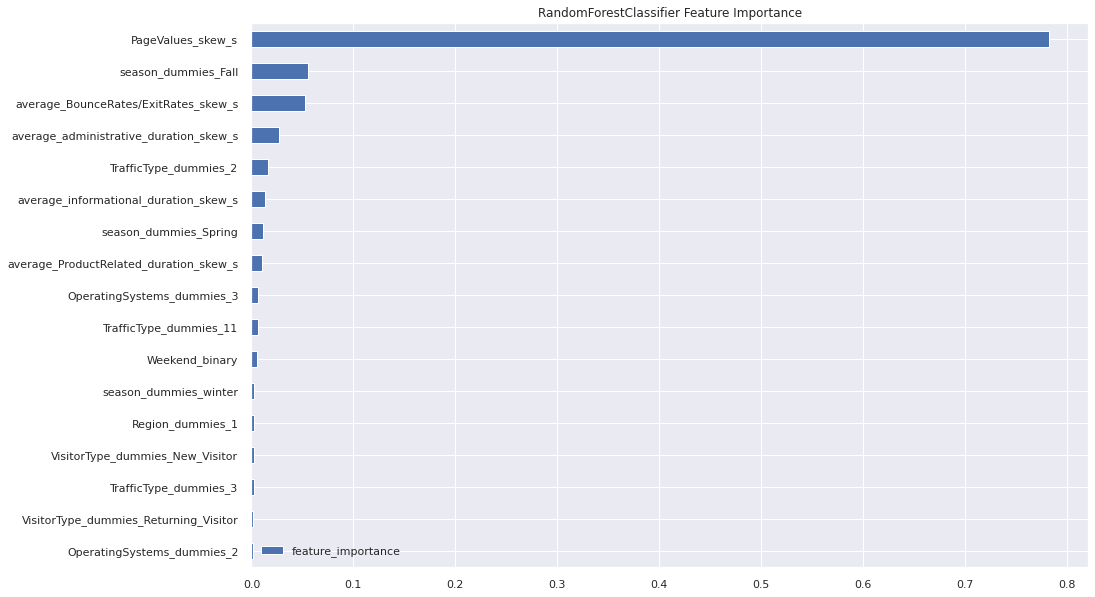

In [25]:
#https://stackoverflow.com/questions/41900387/mapping-column-names-to-random-forest-feature-importances

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(best_features_spsa, rf_model.feature_importances_):
    feats[feature] = importance #add the name/value pair 
sns.set()
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature_importance'})
importances.sort_values(by='feature_importance').plot(kind='barh', rot=0 , figsize=(15,10) ,title ='RandomForestClassifier Feature Importance')
importances.sort_values(by='feature_importance').tail(10).index